# Variable Analysis & Modelling

The dataset is imported into my local postgres SQL database in it's original form. I used SQL to do most of the data cleaning and created some new variables. You may refer to sql_2.sql and sql_pt_2.sql for the code.

**Our Data**

* Clinical and financial data of patients hospitalised for a certain (X) condition
* Per row per total bill 
* 3,314 rows 
* 3,000 unique patients
* 5 year data (2011 - 2015)

**Variables**

* Number of encounter per year (continuous)
* More than 1 encounter per year (binary)

* Age (continuous)
* Age (<55, >55) (categorical)
* BMI (continuous)
* BMI Risk Level (categorical)
* Number of Medical History (continuous)
* Medical History 1 through 7 (binary)
* Symptoms 1 through 5 (binary)

Total number of data = 3,312 (per row per admission)

In [1]:
# import packages

import psycopg2
import pandas as pd
import numpy as np

# stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from sklearn.feature_selection import chi2
import statsmodels.regression.linear_model as lm

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Processing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import tree


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# display options

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',200)

In [2]:
# connect to database

engine = psycopg2.connect("dbname=holmusk user=joannasyeow")
f = open("sql_2.sql", "r")
sql = f.read()
df = pd.read_sql(sql, con=engine)

# Apply natural log to target variable - See 1_eda for explanation

df['log_bill'] = np.log(df['tot_bill'])

In [3]:
# have a quick look at our data

df.head()

,id_,patient_id,medical_history_1,medical_history_2_c,medical_history_3_c,medical_history_4,medical_history_5_c,medical_history_6,medical_history_7,no_med_hist,age_at_adm,age_grp,gender_c,race_c,resident_status_c,bmi,bmi_risk,bmi_high,indian,chinese,malay,other,sg,pr,foreigner,not_sg,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,no_sym,tot_bill,log_bill
0,8461069832,00225710a878eff524a1d13be817e8e2,0,0,0,0,0,0,1,1,31,0,1,2,0,27.85,4,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,5190.57,8.554599
1,5621737529,0029d90eb654699c18001c17efb0f129,0,1,0,0,0,1,0,2,69,1,1,2,0,34.80,4,1,0,1,0,0,1,0,0,0,0,1,0,0,1,2,22601.50,10.025772
2,9921582850,0040333abd68527ecb53e1db9073f52e,0,1,0,0,0,0,1,2,41,0,0,1,0,26.87,3,0,1,0,0,0,1,0,0,0,0,1,0,0,1,2,17447.18,9.766933
3,7239419545,00473b58e3dc8ae37b3cb34069705083,1,0,0,0,0,0,0,1,38,0,1,2,0,31.68,4,1,0,1,0,0,1,0,0,0,0,1,1,1,0,3,15285.88,9.634685
4,9476531069,0078662d1d983dde68ea057c42d5b5cf,0,1,0,0,0,1,0,2,70,1,0,3,2,24.96,3,0,0,0,1,0,0,0,1,1,0,1,0,1,1,3,73477.87,11.204740


In [4]:
df.describe()

,id_,medical_history_1,medical_history_2_c,medical_history_3_c,medical_history_4,medical_history_5_c,medical_history_6,medical_history_7,no_med_hist,age_at_adm,age_grp,gender_c,race_c,resident_status_c,bmi,bmi_risk,bmi_high,indian,chinese,malay,other,sg,pr,foreigner,not_sg,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,no_sym,tot_bill,log_bill
count,3.400000e+03,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,8.004280e+09,0.169118,0.290000,0.136176,0.052059,0.058235,0.254706,0.254412,1.214706,52.542647,0.416471,0.500588,2.214412,0.246176,28.958947,3.554412,0.636176,0.101176,0.637059,0.207941,0.053824,0.801176,0.151471,0.047353,0.198824,0.619706,0.662353,0.544706,0.726471,0.526765,3.080000,21859.071256,9.894206
std,1.610701e+09,0.374911,0.453829,0.343026,0.222178,0.234222,0.435760,0.435594,0.971992,14.681475,0.493046,0.500073,0.691795,0.529492,4.140672,0.643142,0.481169,0.301607,0.480919,0.405894,0.225702,0.399174,0.358560,0.212424,0.399174,0.485530,0.472977,0.498071,0.445836,0.499357,1.068724,10155.336729,0.446753
min,1.350319e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,1.000000,0.000000,17.510000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2946.100000,7.988238
25%,7.094585e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000,2.000000,0.000000,26.160000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14793.372500,9.601935
50%,8.370572e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,51.000000,0.000000,1.000000,2.000000,0.000000,28.940000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,20180.020000,9.912448
75%,9.293090e+09,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,65.000000,1.000000,1.000000,3.000000,0.000000,31.712500,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,26680.295000,10.191681
max,9.999633e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,85.000000,1.000000,1.000000,4.000000,2.000000,46.680000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,98723.850000,11.500082


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 34 columns):
id_                    3400 non-null int64
patient_id             3400 non-null object
medical_history_1      3400 non-null int64
medical_history_2_c    3400 non-null int64
medical_history_3_c    3400 non-null int64
medical_history_4      3400 non-null int64
medical_history_5_c    3400 non-null int64
medical_history_6      3400 non-null int64
medical_history_7      3400 non-null int64
no_med_hist            3400 non-null int64
age_at_adm             3400 non-null int64
age_grp                3400 non-null int64
gender_c               3400 non-null int64
race_c                 3400 non-null int64
resident_status_c      3400 non-null int64
bmi                    3400 non-null float64
bmi_risk               3400 non-null int64
bmi_high               3400 non-null int64
indian                 3400 non-null int64
chinese                3400 non-null int64
malay                  3400 no

In [6]:
# check for duplicated rows

len(df.loc[df.duplicated(), :])

0

# Number of encounters

Readmission - naturally more admission encounters will lead to higher cost per patient.
Chi-square test to see whether there is a relation between other variable and number of encounter per year.

In [7]:
# connect to database

engine = psycopg2.connect("dbname=holmusk user=joannasyeow")
f = open("sql_pt_2.sql", "r")
sql = f.read()
df2 = pd.read_sql(sql, con=engine)

# Apply natural log to target variable

df2['log_bill'] = np.log(df2['tot_bill_yr'])

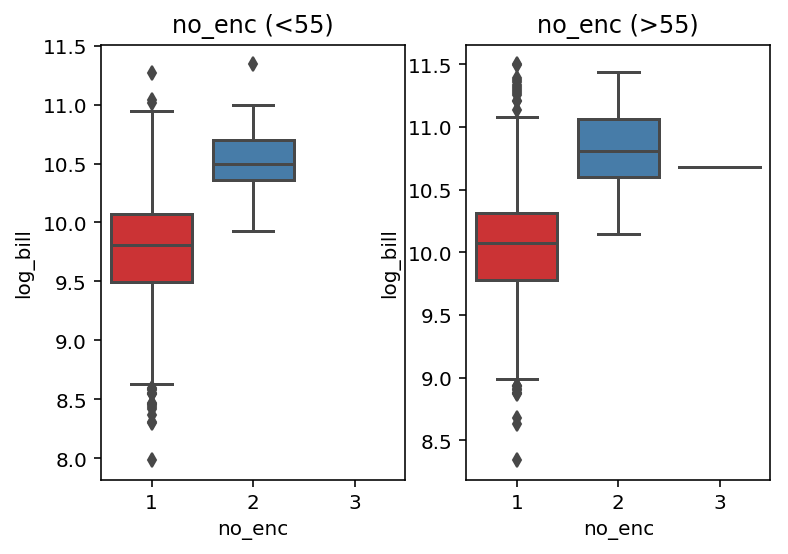


<55
Value Count:
no_enc
1    1716
2      45
Name: patient_id, dtype: int64

Mean Total Bills:
no_enc
1    19332.672672
2    38705.620667
Name: tot_bill_yr, dtype: float64

F: 134.0218654098311
P-value:  5.126439487960793e-30
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
no_enc
1    1219
2      39
3       1
Name: patient_id, dtype: int64

Mean Total Bills:
no_enc
1    25370.378667
2    52565.682564
3    43490.120000
Name: tot_bill_yr, dtype: float64

F: 62.32653663994557
P-value:  1.2354270823948245e-26
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [8]:
fig, ax =plt.subplots(1,2)
sns.boxplot(y=df2[df2['age_grp']==0]['log_bill'],x=df2['no_enc'], ax=ax[0],palette="Set1").set_title("no_enc (<55)")
sns.boxplot(y=df2[df2['age_grp']==1]['log_bill'],x=df2['no_enc'], ax=ax[1],palette="Set1").set_title("no_enc (>55)")
plt.show()

print()
print('<55')
print('Value Count:')
print(df2[df2['age_grp']==0].groupby('no_enc')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df2[df2['age_grp']==0].groupby('no_enc')['tot_bill_yr'].mean())
print()

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df2[df2['age_grp']==0][df2['no_enc'] == 1]['log_bill'],df2[df2['age_grp']==0][df2['no_enc'] == 2]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

print()   
print('##########################')    
print('>55')
print('Value Count:')
print(df2[df2['age_grp']==1].groupby('no_enc')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df2[df2['age_grp']==1].groupby('no_enc')['tot_bill_yr'].mean())
print()
# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df2[df2['age_grp']==1][df2['no_enc'] == 1]['log_bill'],df2[df2['age_grp']==1][df2['no_enc'] == 2]['log_bill'],df2[df2['age_grp']==1][df2['no_enc'] == 3]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


In [9]:
print('Value Count:')
print(df2.groupby('no_enc')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df2.groupby('no_enc')['tot_bill_yr'].mean())
print()

# number of encounters

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df2[df2['no_enc'] == 1]['log_bill'],df2[df2['no_enc'] == 2]['log_bill'],df2[df2['no_enc'] == 3]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


Value Count:
no_enc
1    2928
2      84
3       1
Name: patient_id, dtype: int64

Mean Total Bills:
no_enc
1    21828.906027
2    45140.649405
3    43490.120000
Name: tot_bill_yr, dtype: float64

F: 122.83687109051233
P-value:  3.459666718028266e-52
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


                     medical_history_1  medical_history_6  medical_history_7  \
medical_history_1             0.000000       8.522587e-01           0.513132   
medical_history_6             0.860098       0.000000e+00           0.964890   
medical_history_7             0.536067       9.648970e-01           0.000000   
medical_history_2_c           0.741416       6.535325e-01           0.461015   
medical_history_3_c           0.773791       5.326718e-01           0.522027   
medical_history_4             0.371769       1.870426e-01           0.416594   
medical_history_5_c           0.955893       3.624108e-01           0.460091   
bmi_high                      0.742419       7.544613e-01           0.963060   
age_grp                       0.047228       3.619291e-01           0.939487   
readm                         0.003221       6.765613e-10           0.000225   
resident_status_c             0.889111       6.907809e-01           0.032914   
race_c                        0.607944  

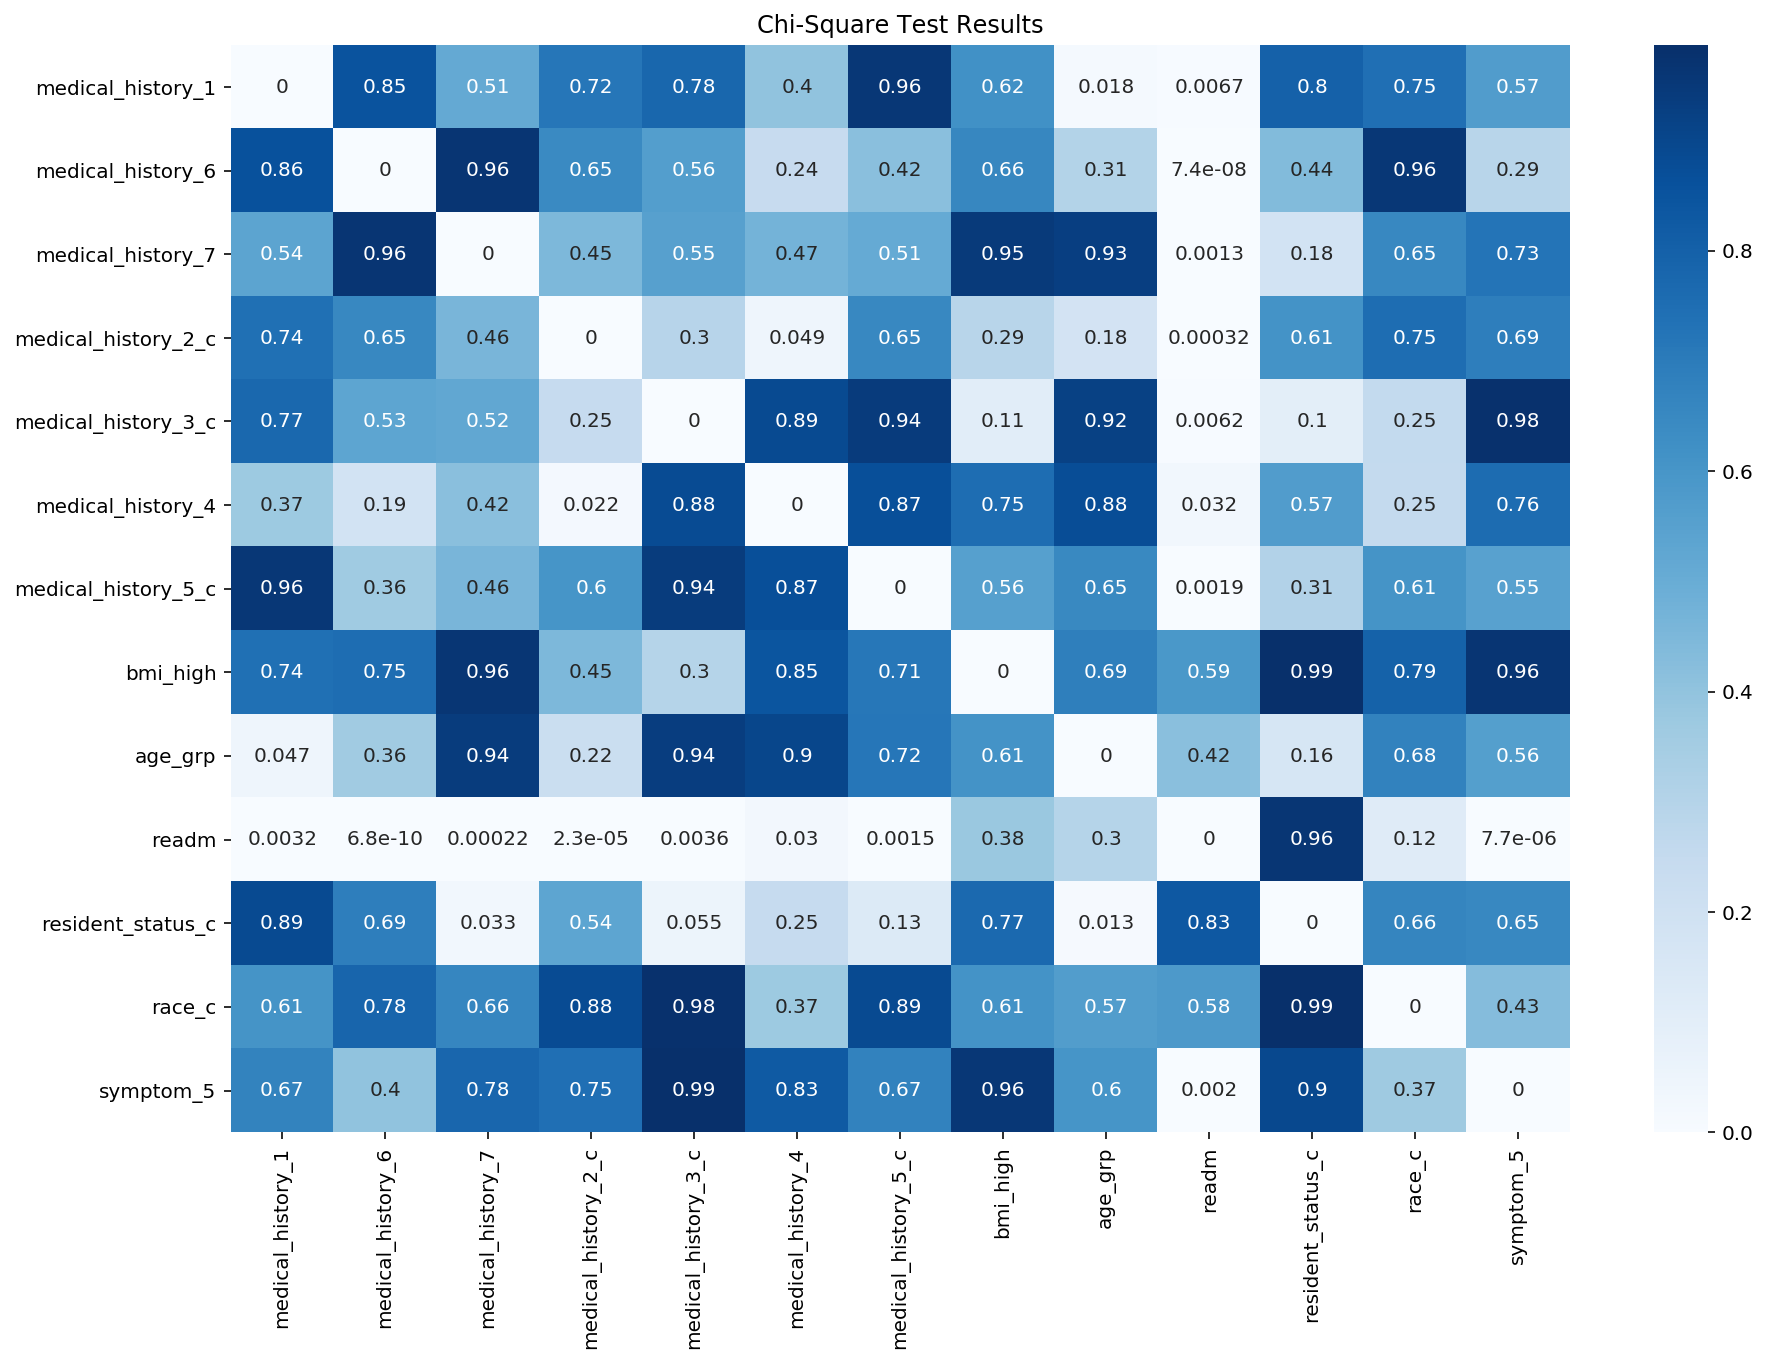

In [10]:
# CHI 2 Test 

A = df2[['medical_history_1','medical_history_6','medical_history_7','medical_history_2_c','medical_history_3_c','medical_history_4','medical_history_5_c','bmi_high','age_grp','readm','resident_status_c','race_c','symptom_5']]

resultant = pd.DataFrame(data=[(0 for i in range(len(A.columns))) for i in range(len(A.columns))], 
                         columns=list(A.columns))
resultant.set_index(pd.Index(list(A.columns)), inplace = True)

# Finding p_value for all columns and putting them in the resultant matrix
for i in list(A.columns):
    for j in list(A.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(A[i]).reshape(-1, 1), np.array(A[j]).reshape(-1, 1))
            resultant.loc[i,j] = p_val
print(resultant)

# Plotting a heatmap
fig = plt.figure(figsize=(15,10))
sns.heatmap(resultant, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.show()

# Medical History Analysis

In [11]:
hist_col = ['no_med_hist','medical_history_1','medical_history_2_c','medical_history_3_c','medical_history_4','medical_history_5_c','medical_history_6','medical_history_7']

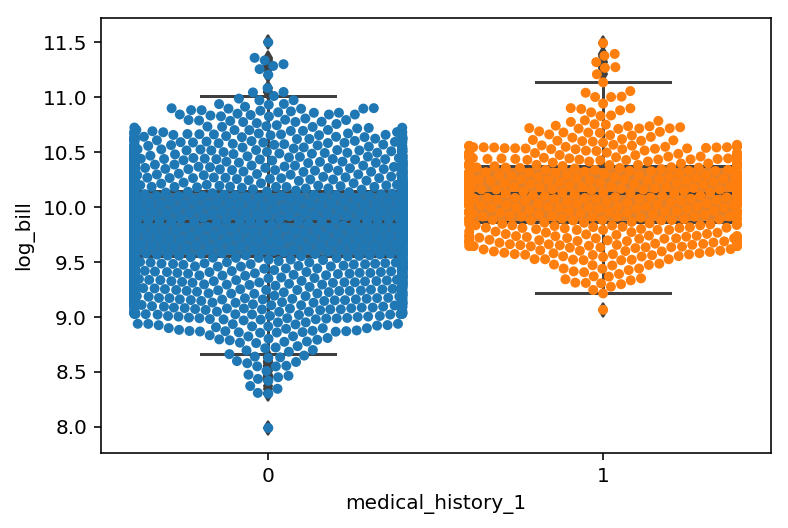

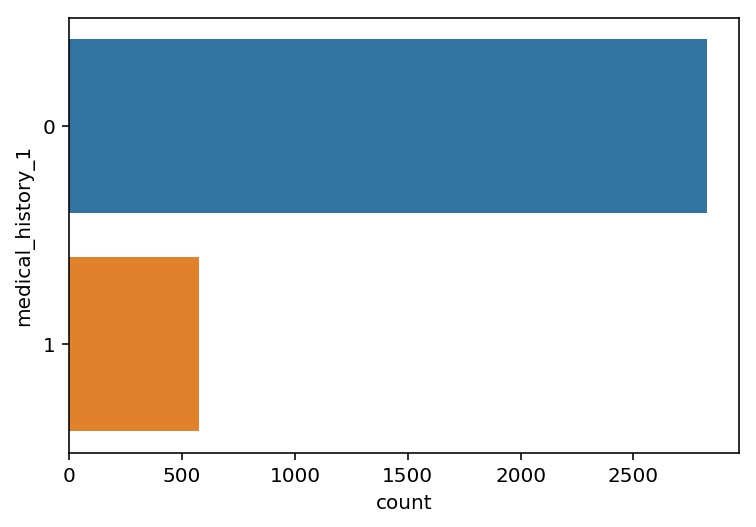


Value Count:
medical_history_1
0    2547
1     562
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    20821.406389
1    26957.163861
Name: tot_bill, dtype: float64



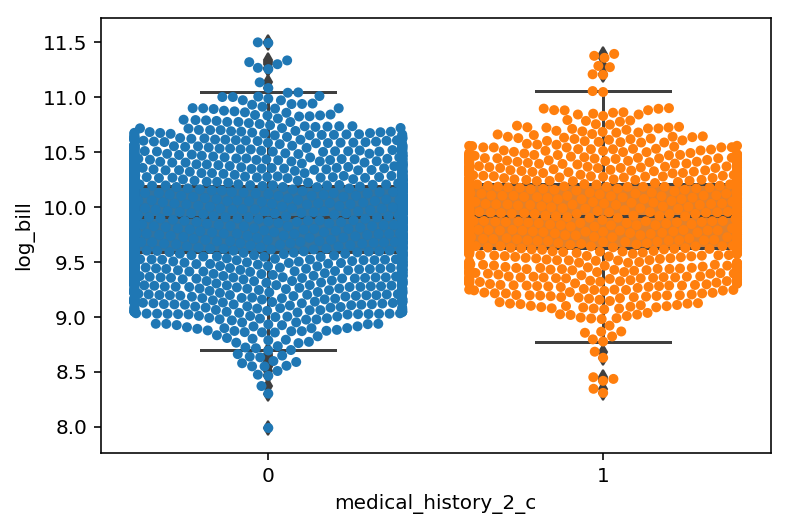

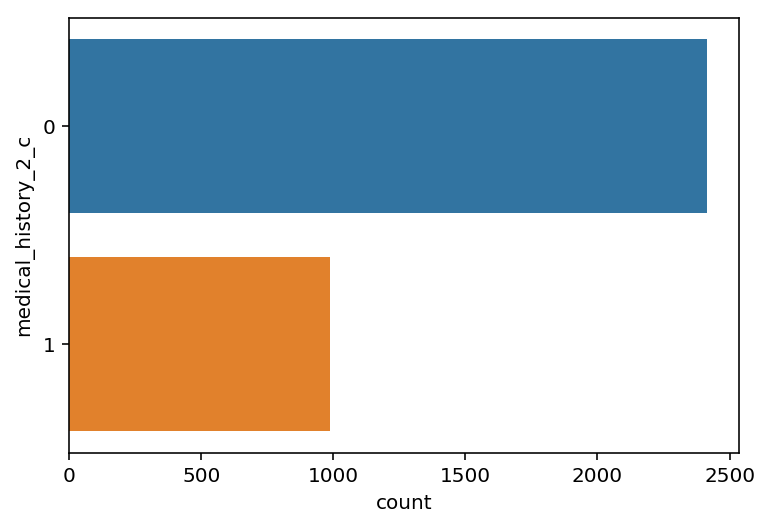


Value Count:
medical_history_2_c
0    2208
1     953
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    21641.128571
1    22392.655071
Name: tot_bill, dtype: float64



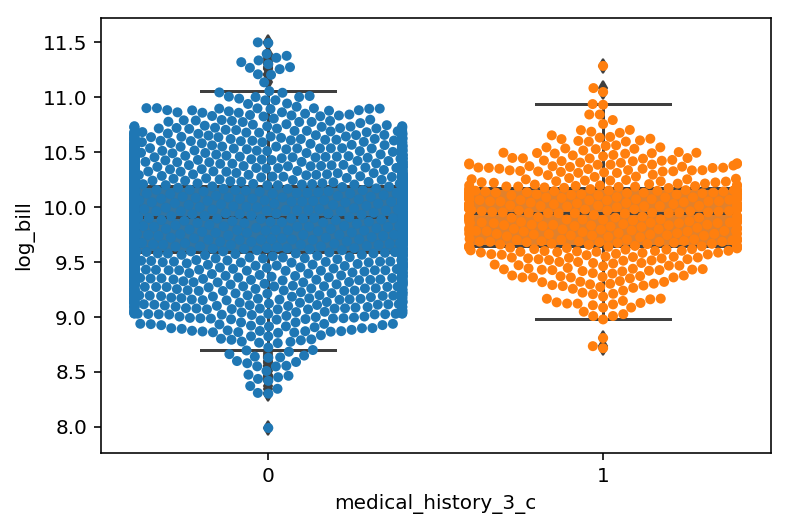

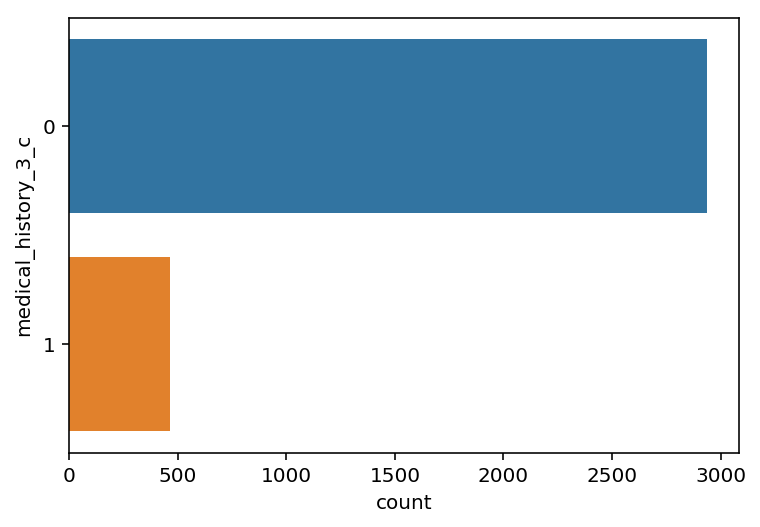


Value Count:
medical_history_3_c
0    2640
1     459
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_3_c
0    21812.549629
1    22154.177127
Name: tot_bill, dtype: float64



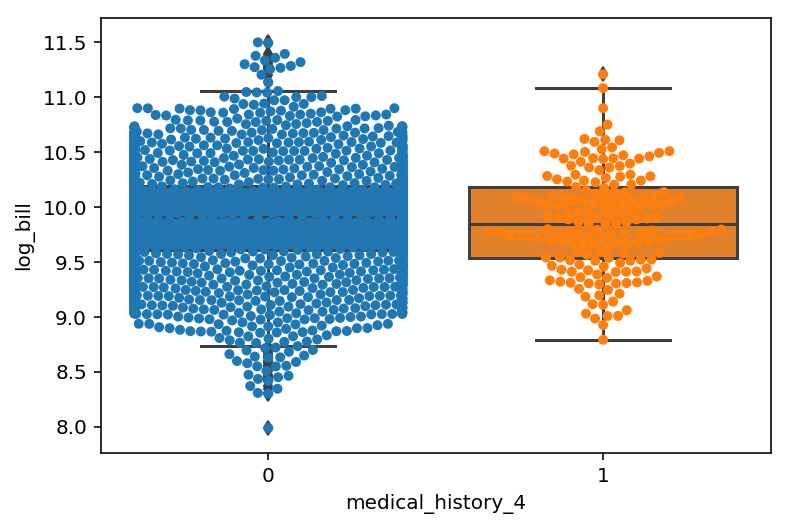

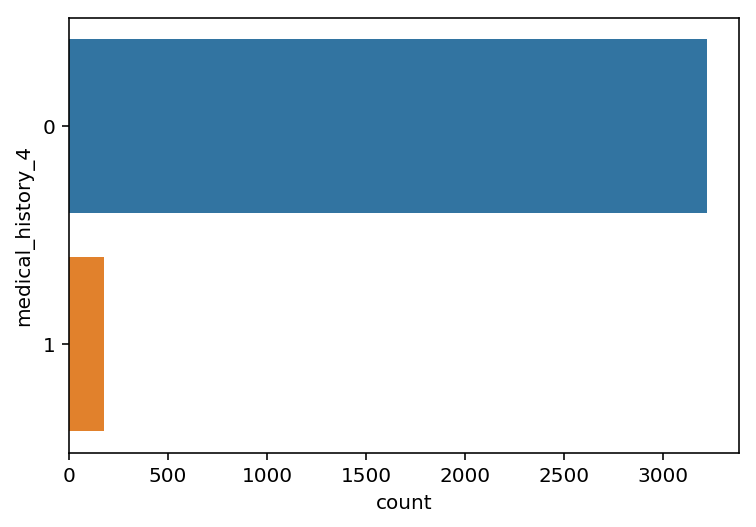


Value Count:
medical_history_4
0    2856
1     175
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_4
0    21881.334977
1    21453.670282
Name: tot_bill, dtype: float64



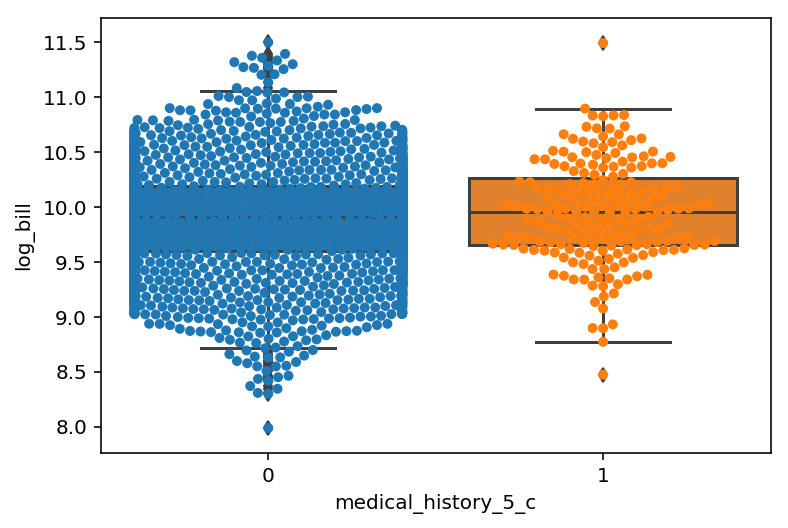

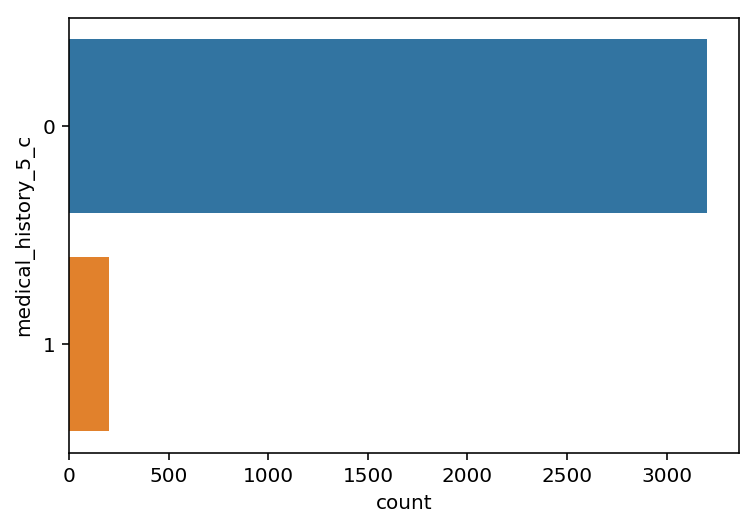


Value Count:
medical_history_5_c
0    2848
1     196
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_5_c
0    21766.19703
1    23361.00697
Name: tot_bill, dtype: float64



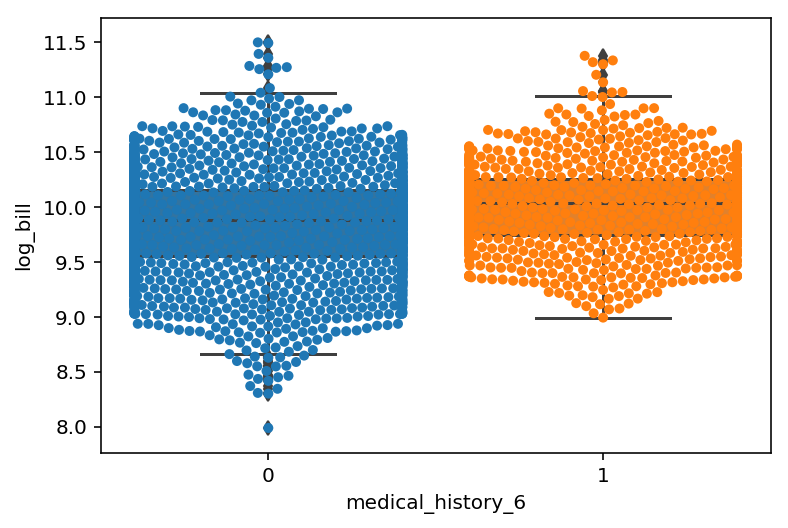

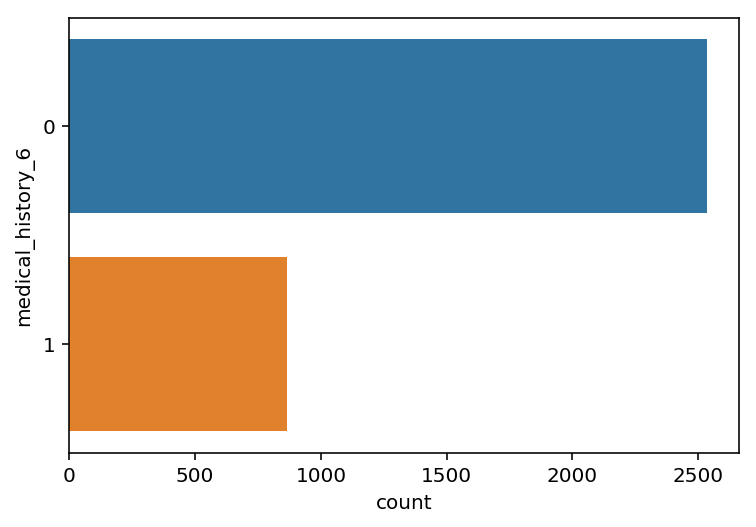


Value Count:
medical_history_6
0    2325
1     839
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    21018.311989
1    24319.214423
Name: tot_bill, dtype: float64



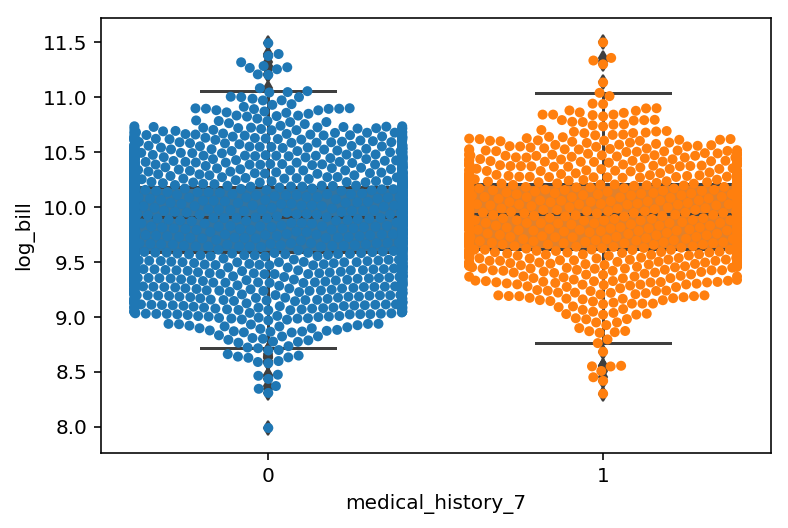

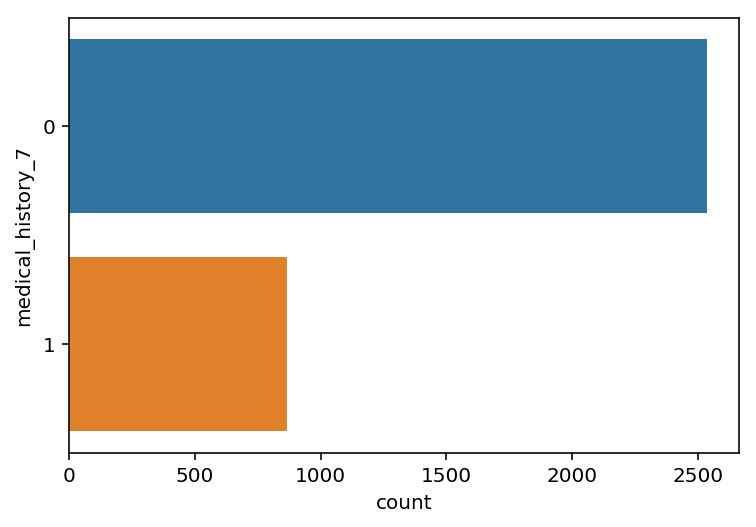


Value Count:
medical_history_7
0    2303
1     842
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    21628.038521
1    22536.144069
Name: tot_bill, dtype: float64



In [12]:
# descriptive analysis for Medical History data

for c in hist_col: 
    if c is not 'no_med_hist':
        sns.boxplot(y=df['log_bill'],x=df[c])
        sns.swarmplot(y=df['log_bill'],x=df[c])
        plt.show()
        sns.countplot(y = df[c])
        plt.show()
        print()
        print('Value Count:')
        print(df.groupby(c)['patient_id'].nunique())
        print()
        print('Mean Total Bills:')
        print(df.groupby(c)['tot_bill'].mean())
        print()

In [13]:
# ONE WAY ANOVA for Medical Historys

for c in hist_col:
    if c != 'no_med_hist':
        # stats f_oneway function
        fvalue, pvalue = stats.f_oneway(df[df[c] == 0]['log_bill'],df[df[c] == 1]['log_bill'])
        print('----------')
        print(c)
        print('----------')
        print('F:',fvalue)
        print('P-value: ',pvalue)
        if pvalue < 0.01 :
            print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
            print('Hypothesis: Pass')
        else:
            print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

----------
medical_history_1
----------
F: 196.3888988725316
P-value:  2.0272014816497924e-43
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass
----------
medical_history_2_c
----------
F: 3.2011838916081174
P-value:  0.07367402075069242
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.
----------
medical_history_3_c
----------
F: 2.2427075283406497
P-value:  0.13433861422371435
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.
----------
medical_history_4
----------
F: 0.5376736608202649
P-value:  0.46344902161924484
Since pvalue is > 0.01, we are unable to re

### Taking a deeper look into Number of Medical History, Medical History 1 and Medical History 6

** Number of medical history **

R:  0.1948047042016401
P-value:  1.9823419533475522e-30


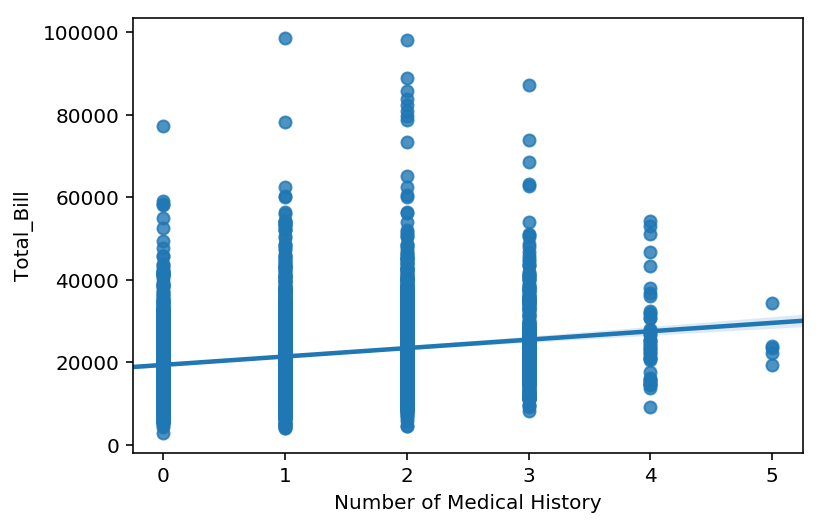

In [14]:
# Pearson Corrleation Coefficient on number of medical history
print ('R: ',stats.pearsonr(df['no_med_hist'], df['tot_bill'])[0])
print ('P-value: ',stats.pearsonr(df['no_med_hist'], df['tot_bill'])[1])

b = sns.regplot(df['no_med_hist'],df['tot_bill'])
b.set_xlabel("Number of Medical History",fontsize=10)
b.set_ylabel("Total_Bill",fontsize=10)
plt.show()

In [15]:
# ONE WAY ANOVA for Number of Medical History

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['no_med_hist'] == 0]['log_bill'],df[df['no_med_hist'] == 1]['log_bill'],df[df['no_med_hist'] == 2]['log_bill'],df[df['no_med_hist'] == 3]['log_bill'],df[df['no_med_hist'] == 4]['log_bill'],df[df['no_med_hist'] == 5]['log_bill'],)
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

F: 31.101859704444454
P-value:  4.725494894223119e-31
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


** Medical History 1, 6  **

In [16]:
# Medical History 1

print(( df[df['medical_history_1'] == 1]['tot_bill'].sum() / df['tot_bill'].sum() ) * 100,'% of total bills came from patients with medical_history_1')

20.856019316477536 % of total bills came from patients with medical_history_1


In [17]:
# Medical History 6

print(( df[df['medical_history_6'] == 1]['tot_bill'].sum() / df['tot_bill'].sum() ) * 100,'% of total bills came from patients with medical_history_6')

28.337191892268365 % of total bills came from patients with medical_history_6


In [18]:
# sns.set(rc={"figure.figsize": (15, 10)})

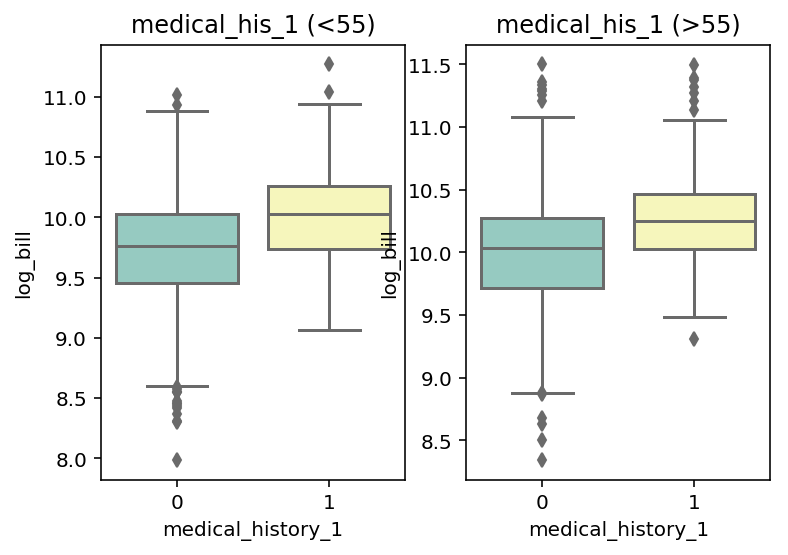


<55
Value Count:
medical_history_1
0    1513
1     302
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    18485.553922
1    23930.524822
Name: tot_bill, dtype: float64

F: 117.33021981678988
P-value:  1.3296376203793124e-26
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
medical_history_1
0    1038
1     260
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    24223.626287
1    30473.071617
Name: tot_bill, dtype: float64

F: 76.29538450684578
P-value:  6.771620281376329e-18
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


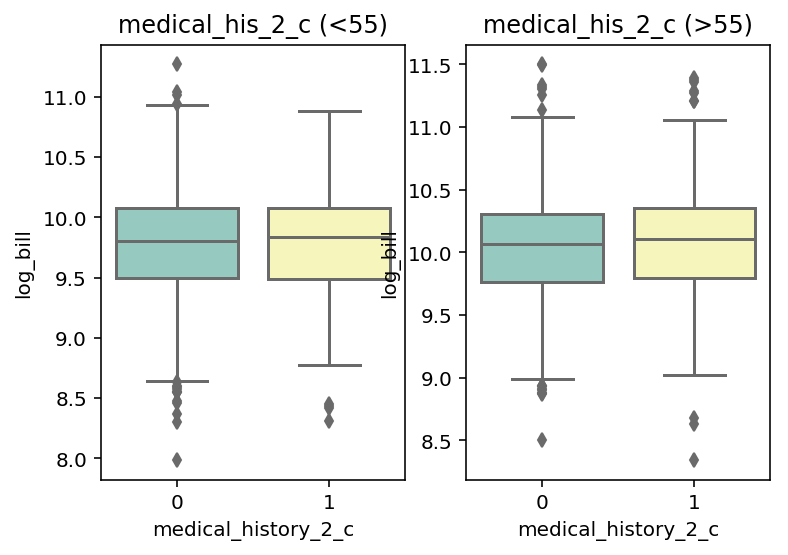


<55
Value Count:
medical_history_2_c
0    1315
1     537
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    19284.447693
1    19459.162330
Name: tot_bill, dtype: float64

F: 0.41769788448713363
P-value:  0.5181628216022214
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_2_c
0    896
1    417
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    25042.572834
1    26217.161963
Name: tot_bill, dtype: float64

F: 2.192641157905499
P-value:  0.13889413001762851
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.


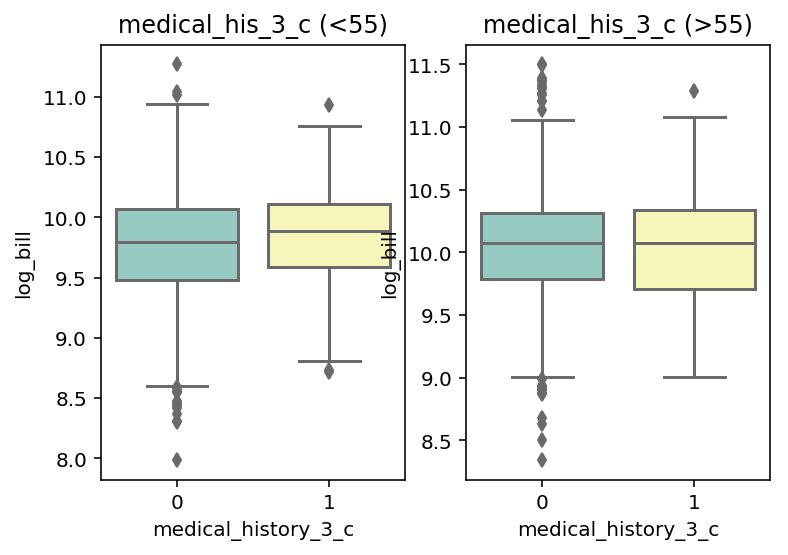


<55
Value Count:
medical_history_3_c
0    1551
1     269
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_3_c
0    19206.767629
1    20131.797096
Name: tot_bill, dtype: float64

F: 6.096454225157806
P-value:  0.013629098054325143
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_3_c
0    1095
1     190
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_3_c
0    25454.262922
1    25034.215707
Name: tot_bill, dtype: float64

F: 0.15747849819020543
P-value:  0.6915485767162398
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.


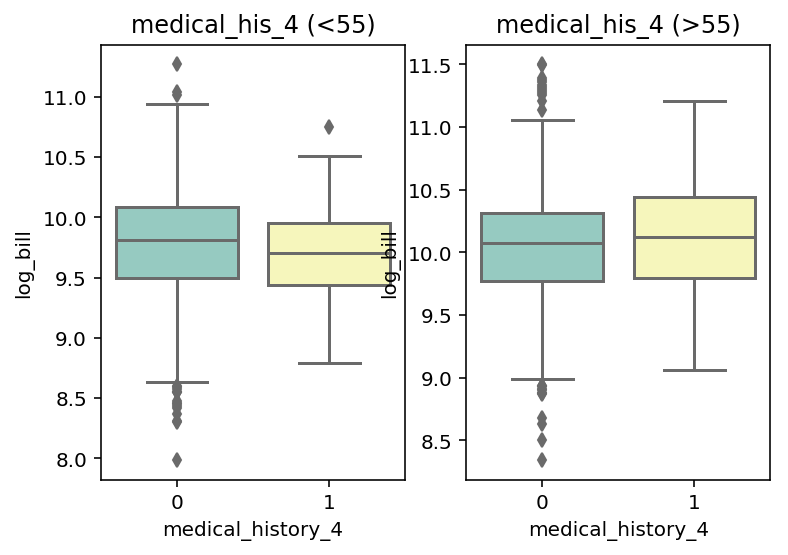


<55
Value Count:
medical_history_4
0    1672
1     103
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_4
0    19418.714007
1    17810.203524
Name: tot_bill, dtype: float64

F: 2.984528172428468
P-value:  0.08421956249957109
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_4
0    1191
1      72
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_4
0    25324.240335
1    26767.059306
Name: tot_bill, dtype: float64

F: 0.994150072103073
P-value:  0.3189007644964248
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.


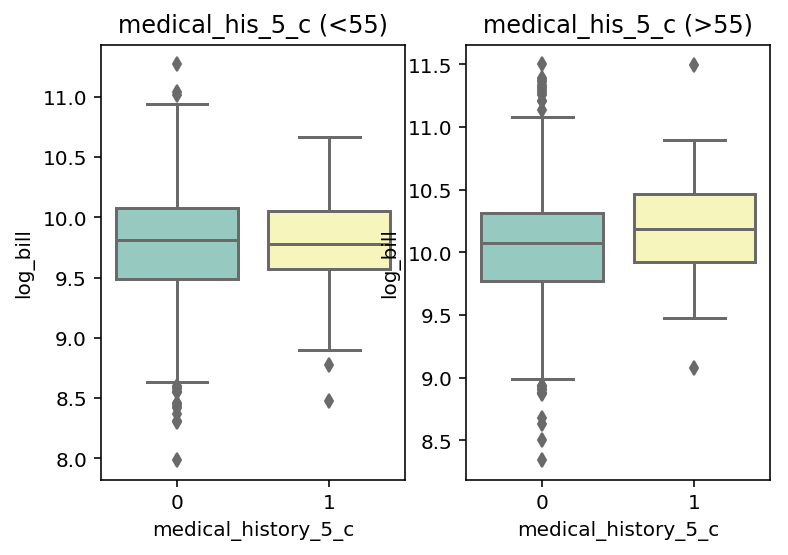


<55
Value Count:
medical_history_5_c
0    1665
1     117
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_5_c
0    19331.197357
1    19371.024538
Name: tot_bill, dtype: float64

F: 0.06136447028958441
P-value:  0.8043778528400416
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_5_c
0    1190
1      79
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_5_c
0    25162.812132
1    29371.233671
Name: tot_bill, dtype: float64

F: 10.140927970607406
P-value:  0.001481755258574545
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


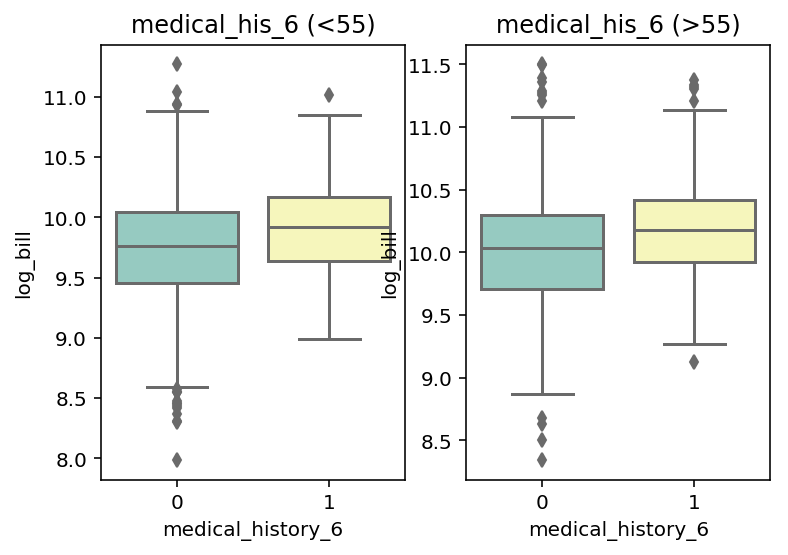


<55
Value Count:
medical_history_6
0    1346
1     506
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    18563.624022
1    21490.070249
Name: tot_bill, dtype: float64

F: 60.746532382501655
P-value:  1.0398615630053344e-14
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
medical_history_6
0    984
1    333
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    24366.030093
1    28612.276221
Name: tot_bill, dtype: float64

F: 47.8118241465957
P-value:  7.081728960496022e-12
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


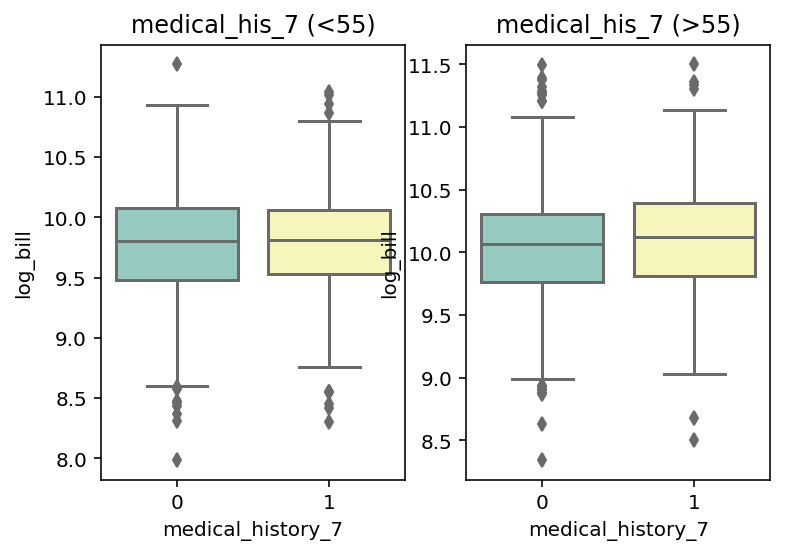


<55
Value Count:
medical_history_7
0    1344
1     496
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    19246.590291
1    19587.696719
Name: tot_bill, dtype: float64

F: 0.47063434824876166
P-value:  0.49277572229193345
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_7
0    966
1    346
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    24958.010596
1    26691.894373
Name: tot_bill, dtype: float64

F: 6.482951189673121
P-value:  0.01099670957021283
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.


In [19]:
for x in ['1','2_c','3_c','4','5_c','6','7']:

    fig, ax =plt.subplots(1,2)

    sns.boxplot(y=df[df['age_grp']==0]['log_bill'],x=df['medical_history_'+x], ax=ax[0],palette="Set3").set_title("medical_his_"+x+" (<55)")
    sns.boxplot(y=df[df['age_grp']==1]['log_bill'],x=df['medical_history_'+x], ax=ax[1],palette="Set3").set_title("medical_his_"+x+" (>55)")
    plt.show()

    print()
    print('<55')
    print('Value Count:')
    print(df[df['age_grp']==0].groupby('medical_history_'+x)['patient_id'].nunique())
    print()
    print('Mean Total Bills:')
    print(df[df['age_grp']==0].groupby('medical_history_'+x)['tot_bill'].mean())
    print()
    
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['age_grp']==0][df['medical_history_'+x] == 0]['log_bill'],df[df['age_grp']==0][df['medical_history_'+x] == 1]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')
    
    print()   
    print('##########################')    
    print('>55')
    print('Value Count:')
    print(df[df['age_grp']==1].groupby('medical_history_'+x)['patient_id'].nunique())
    print()
    print('Mean Total Bills:')
    print(df[df['age_grp']==1].groupby('medical_history_'+x)['tot_bill'].mean())
    print()
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['age_grp']==1][df['medical_history_'+x] == 0]['log_bill'],df[df['age_grp']==1][df['medical_history_'+x] == 1]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')
    

# Symptoms Analysis

** Symptoms 1 to 5 **

A deep dive to have a look at how symptoms impacts the cost of care in an admission

R:  0.5096840388080445
P-value:  2.9842191309705267e-224


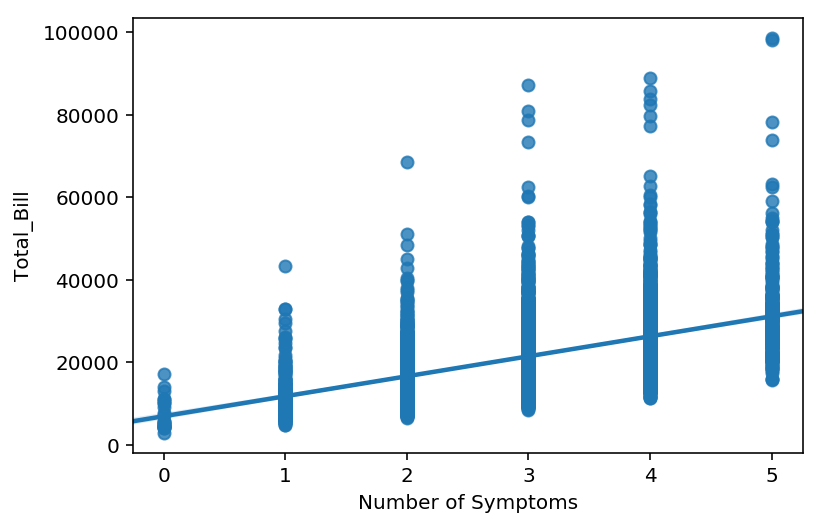

In [21]:
# number of symptoms

# Pearson Corrleation Coefficient on number of symptoms
print ('R: ',stats.pearsonr(df['no_sym'], df['tot_bill'])[0])
print ('P-value: ',stats.pearsonr(df['no_sym'], df['tot_bill'])[1])

b = sns.regplot(df['no_sym'],df['tot_bill'])
b.set_xlabel("Number of Symptoms",fontsize=10)
b.set_ylabel("Total_Bill",fontsize=10)
plt.show()

In [22]:
print('Value Count:')
print(df.groupby('no_sym')['id_'].nunique())
print()
print('Mean Total Bills:')
print(df.groupby('no_sym')['tot_bill'].mean())
print()

Value Count:
no_sym
0      25
1     209
2     748
3    1196
4     931
5     291
Name: id_, dtype: int64

Mean Total Bills:
no_sym
0     7477.145200
1    12063.597990
2    16637.527340
3    21296.331823
4    26421.502642
5    31267.764227
Name: tot_bill, dtype: float64



Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.4997 0.001 0.2843 0.7151   True
     0      2   0.8378 0.001 0.6308 1.0447   True
     0      3   1.0873 0.001 0.8816  1.293   True
     0      4   1.3172 0.001 1.1109 1.5234   True
     0      5   1.4952 0.001 1.2831 1.7073   True
     1      2   0.3381 0.001 0.2585 0.4177   True
     1      3   0.5876 0.001 0.5113 0.6639   True
     1      4   0.8175 0.001 0.7396 0.8954   True
     1      5   0.9955 0.001 0.9032 1.0878   True
     2      3   0.2495 0.001  0.202 0.2969   True
     2      4   0.4794 0.001 0.4294 0.5294   True
     2      5   0.6574 0.001 0.5871 0.7277   True
     3      4   0.2299 0.001 0.1854 0.2744   True
     3      5   0.4079 0.001 0.3414 0.4745   True
     4      5    0.178 0.001 0.1097 0.2464   True
-------------------------------------------------


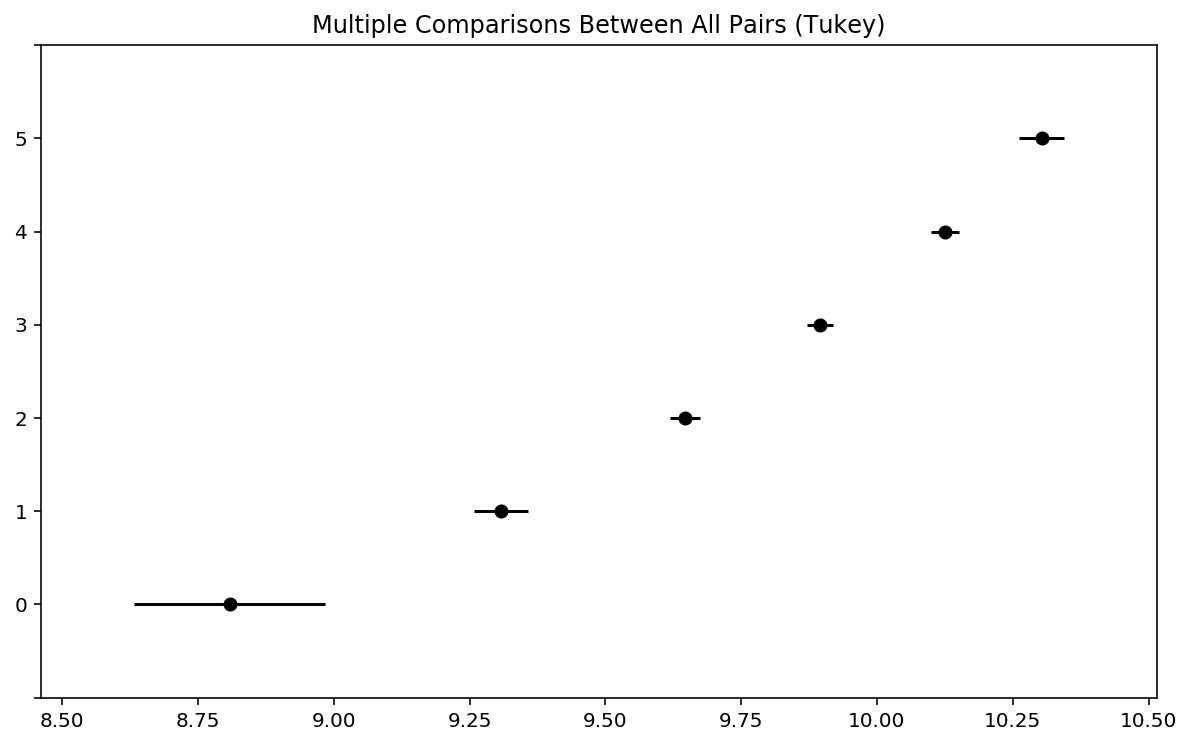

In [23]:
def tukey_hsd(df,col,aspect='log_bill'):

    # DataFrame.
    tukeyhsd = multi.pairwise_tukeyhsd(df[aspect].values,df[col].values, alpha=0.05)
    result = tukeyhsd.summary()
    print(result)

    #visualisation
    tukeyhsd.plot_simultaneous(figsize=(10,6))
    
tukey_hsd(df,'no_sym')

In [24]:
df['tot_bill'].mean()

21859.07125588235

In [25]:
# symptoms

for c in range(1,6): 
    print()
    print('-------')
    print('symptom_'+str(c))
    print('-------')
    
    print('Value Count:')
    print(df.groupby('symptom_'+str(c))['id_'].nunique())
    print()
    print('Mean Total Bills:')
    print(df.groupby('symptom_'+str(c))['tot_bill'].mean())
    print()
    
    
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['symptom_'+str(c)] == 1]['log_bill'], df[df['symptom_'+str(c)] == 0]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


-------
symptom_1
-------
Value Count:
symptom_1
0    1293
1    2107
Name: id_, dtype: int64

Mean Total Bills:
symptom_1
0    20195.861237
1    22879.731224
Name: tot_bill, dtype: float64

F: 82.83957498037284
P-value:  1.4801748876316555e-19
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

-------
symptom_2
-------
Value Count:
symptom_2
0    1148
1    2252
Name: id_, dtype: int64

Mean Total Bills:
symptom_2
0    19614.659329
1    23003.203091
Name: tot_bill, dtype: float64

F: 119.07991812699424
P-value:  2.8365452273614362e-27
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

-------
symptom_3
-------
Value Count:
symptom_3
0    1548
1    1852
Name: id_, dtype: int64

Mean Total Bills:
symptom_3
0    19815.665336
1    23567.058494
Name: tot_bill, dtype: float64

F: 168.42529

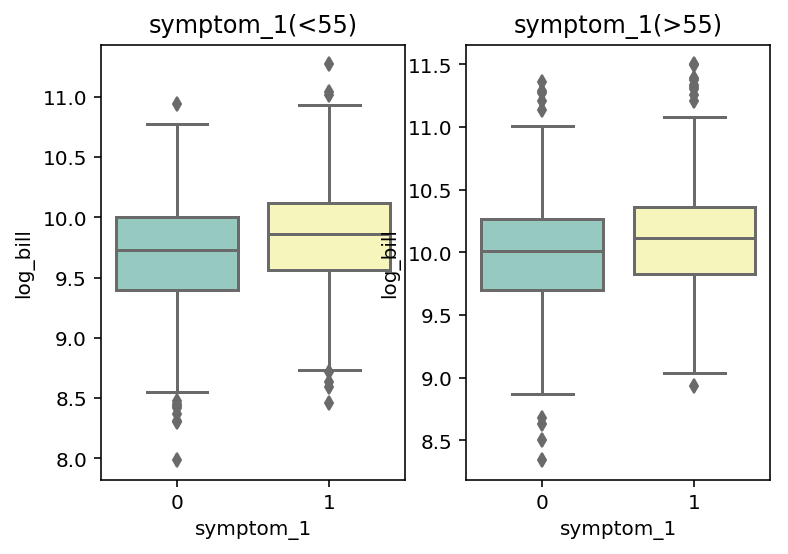


<55
Value Count:
symptom_1
0     758
1    1226
Name: id_, dtype: int64

Mean Total Bills:
symptom_1
0    17702.022784
1    20342.334192
Name: tot_bill, dtype: float64

F: 61.327650104911946
P-value:  7.809341983366335e-15
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
symptom_1
0    535
1    881
Name: id_, dtype: int64

Mean Total Bills:
symptom_1
0    23729.187495
1    26410.774086
Name: tot_bill, dtype: float64

F:

/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 29.12945112620242
P-value:  7.929193077188865e-08
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


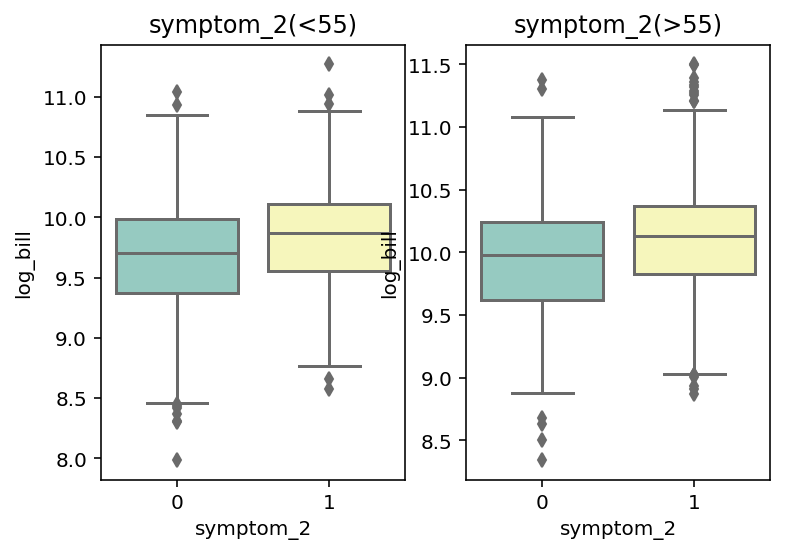


<55
Value Count:
symptom_2
0     666
1    1318
Name: id_, dtype: int64

Mean Total Bills:
symptom_2
0    17440.181892
1    20290.344347
Name: tot_bill, dtype: float64

F: 73.101886937671
P-value:  2.4204742956537318e-17
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
symptom_2
0    482
1    934
Name: id_, dtype: int64

Mean Total Bills:
symptom_2
0    22619.227739
1    26831.412752
Name: tot_bill, dtype: float64

F: 60.12520723923158
P-value:  1.6918919974118648e-14
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


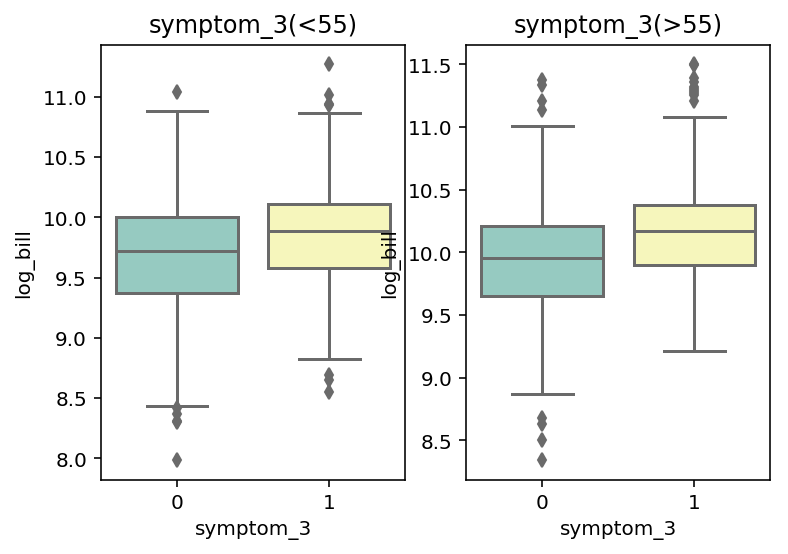


<55
Value Count:
symptom_3
0     916
1    1068
Name: id_, dtype: int64

Mean Total Bills:
symptom_3
0    17864.859596
1    20593.280524
Name: tot_bill, dtype: float64

F: 81.34900043655396
P-value:  4.34955114908524e-19
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
symptom_3
0    632
1    784
Name: id_, dtype: int64

Mean Total Bills:
symptom_3
0    22643.098972
1    27618.072360
Name: tot_bill, dtype: float64

F: 99.74504640510642
P-value:  9.625512956072045e-23
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


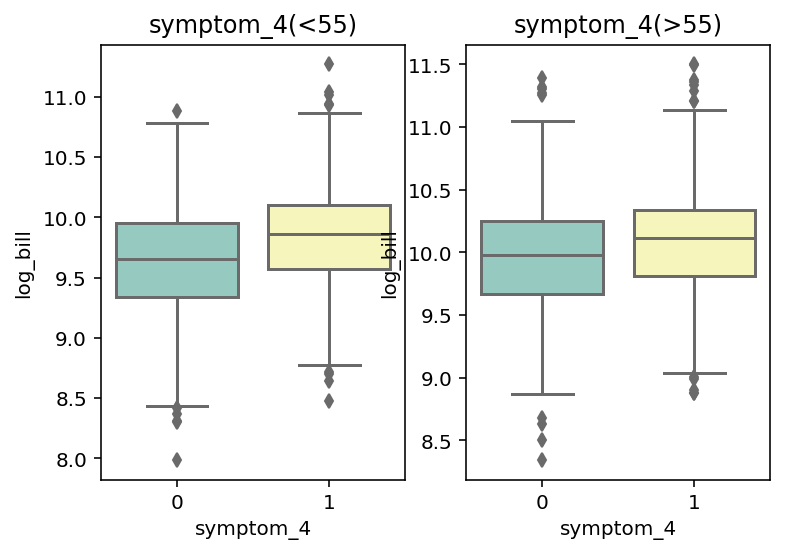


<55
Value Count:
symptom_4
0     531
1    1453
Name: id_, dtype: int64

Mean Total Bills:
symptom_4
0    16907.568098
1    20220.176414
Name: tot_bill, dtype: float64

F: 92.57385636826459
P-value:  1.8930580523890517e-21
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
symptom_4
0     399
1    1017
Name: id_, dtype: int64

Mean Total Bills:
symptom_4
0    23425.477118
1    26171.329312
Name: tot_bill, dtype: float64

F: 29.272309257333387
P-value:  7.376616552938969e-08
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


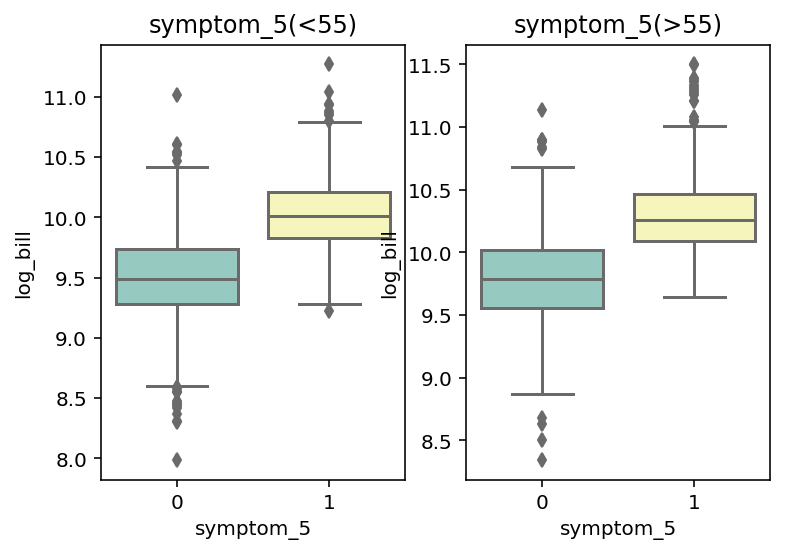


<55
Value Count:
symptom_5
0     927
1    1057
Name: id_, dtype: int64

Mean Total Bills:
symptom_5
0    14354.570852
1    23700.234447
Name: tot_bill, dtype: float64

F: 1223.8118414607725
P-value:  3.215304921880195e-209
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
symptom_5
0    682
1    734
Name: id_, dtype: int64

Mean Total Bills:
symptom_5
0    18998.194223
1    31343.649619
Name: tot_bill, dtype: float64

F: 821.7834212445429
P-value:  7.317470171908425e-143
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


In [26]:
# descriptive analysis for symptoms data

for c in range(1,6): 
    fig, ax =plt.subplots(1,2)

    sns.boxplot(y=df[df['age_grp']==0]['log_bill'],x=df['symptom_'+str(c)], ax=ax[0],palette="Set3").set_title("symptom_"+str(c)+"(<55)")
    sns.boxplot(y=df[df['age_grp']==1]['log_bill'],x=df['symptom_'+str(c)], ax=ax[1],palette="Set3").set_title("symptom_"+str(c)+"(>55)")
    plt.show()

    print()
    print('<55')
    print('Value Count:')
    print(df[df['age_grp']==0].groupby('symptom_'+str(c))['id_'].nunique())
    print()
    print('Mean Total Bills:')
    print(df[df['age_grp']==0].groupby('symptom_'+str(c))['tot_bill'].mean())
    print()

    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['age_grp']==0][df['symptom_'+str(c)] == 0]['log_bill'],df[df['age_grp']==0][df['symptom_'+str(c)] == 1]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

    print()   
    print('##########################')    
    print('>55')
    print('Value Count:')
    print(df[df['age_grp']==1].groupby('symptom_'+str(c))['id_'].nunique())
    print()
    print('Mean Total Bills:')
    print(df[df['age_grp']==1].groupby('symptom_'+str(c))['tot_bill'].mean())
    print()
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['age_grp']==1][df['symptom_'+str(c)] == 0]['log_bill'],df[df['age_grp']==1][df['symptom_'+str(c)] == 1]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


                     medical_history_1  medical_history_6  medical_history_7  \
medical_history_1             0.000000           0.740809           0.869695   
medical_history_6             0.754066           0.000000           0.917934   
medical_history_7             0.876508           0.917918           0.000000   
medical_history_2_c           0.848406           0.777836           0.277545   
medical_history_3_c           0.682312           0.397700           0.441850   
medical_history_4             0.430232           0.117125           0.297959   
medical_history_5_c           0.778259           0.284011           0.790704   
bmi_high                      0.722180           0.769837           0.949116   
age_grp                       0.060006           0.309453           0.939346   
resident_status_c             0.886243           0.702695           0.017058   
race_c                        0.607364           0.797901           0.682351   
symptom_5                     0.575227  

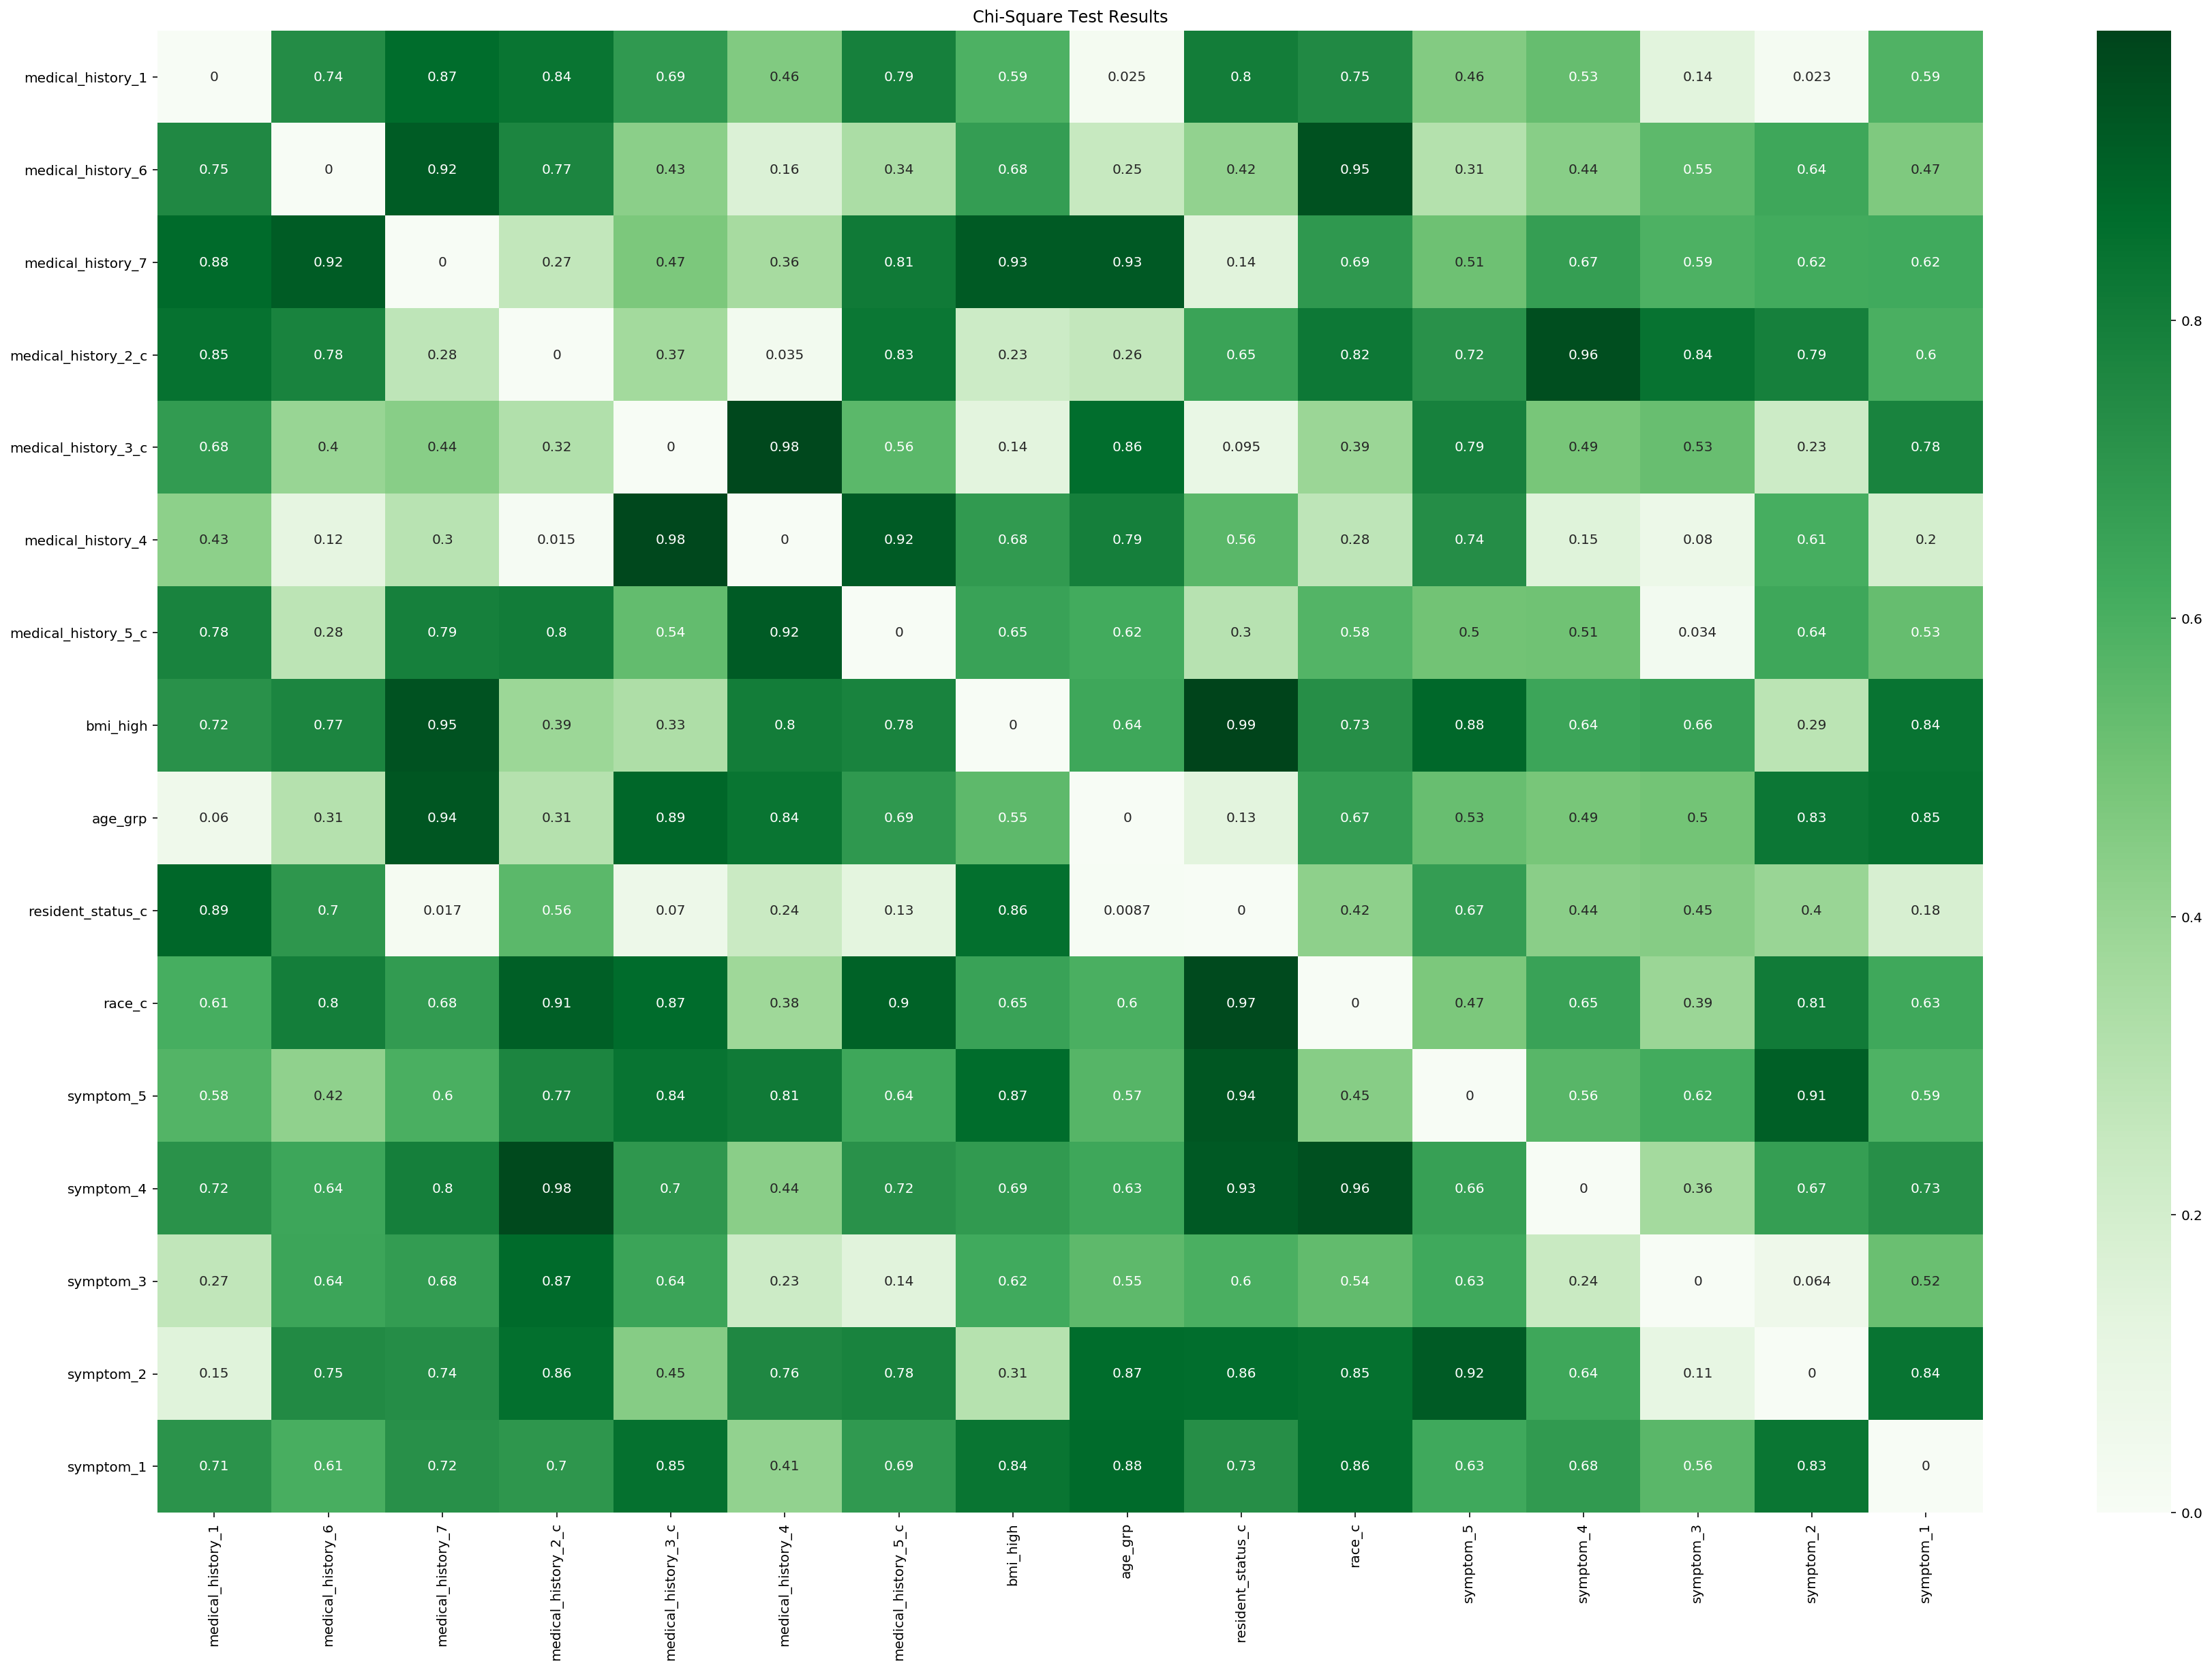

In [27]:
# CHI 2 Test 

A = df[['medical_history_1','medical_history_6','medical_history_7','medical_history_2_c','medical_history_3_c','medical_history_4','medical_history_5_c','bmi_high','age_grp','resident_status_c','race_c','symptom_5','symptom_4','symptom_3','symptom_2','symptom_1']]

resultant = pd.DataFrame(data=[(0 for i in range(len(A.columns))) for i in range(len(A.columns))], 
                         columns=list(A.columns))
resultant.set_index(pd.Index(list(A.columns)), inplace = True)

# Finding p_value for all columns and putting them in the resultant matrix
for i in list(A.columns):
    for j in list(A.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(A[i]).reshape(-1, 1), np.array(A[j]).reshape(-1, 1))
            resultant.loc[i,j] = p_val
print(resultant)

# Plotting a heatmap
fig = plt.figure(figsize=(30,20))
sns.heatmap(resultant, annot=True, cmap='Greens')
plt.title('Chi-Square Test Results')
plt.show()

### BMI

bmi:  28.95894705882353


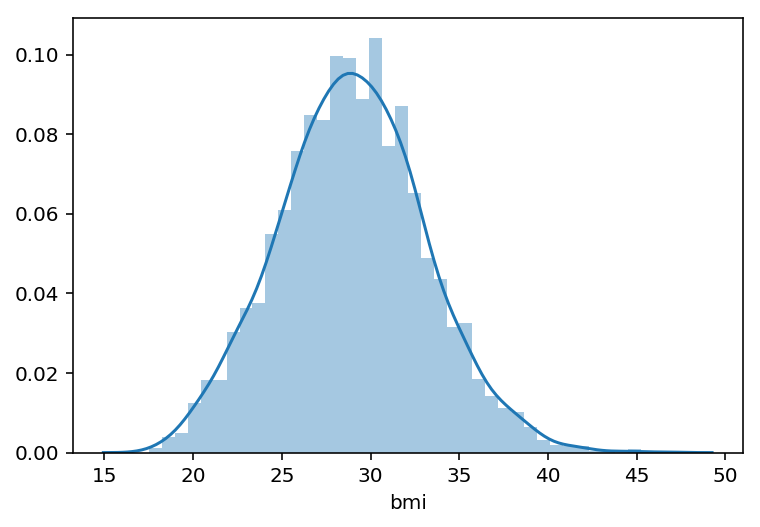

In [28]:
# distribution plot for bmi
print('bmi: ',np.mean(df['bmi']))
sns.distplot(df['bmi'])
plt.show()
print()

R:  0.1403607055931161
P-value:  1.9999028453040658e-16


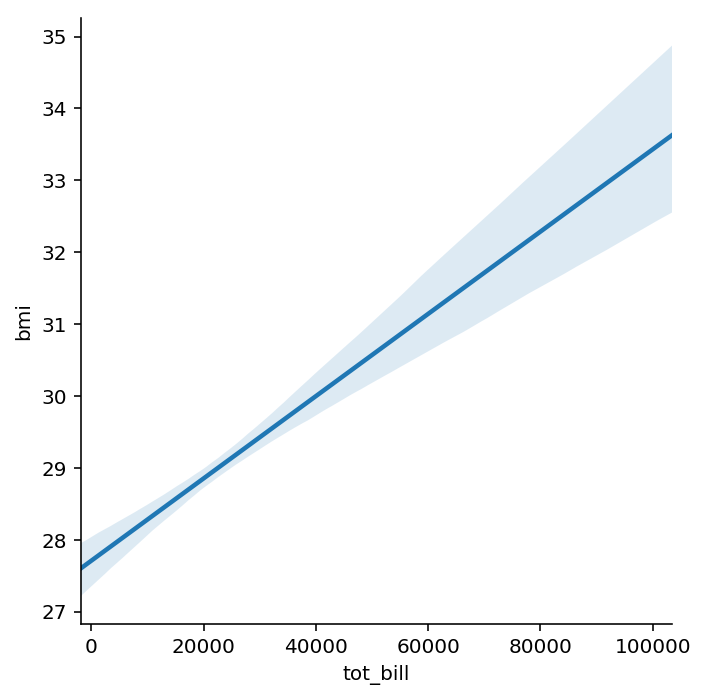

In [29]:
# Pearson Corrleation Coefficient on bmi
print ('R: ',stats.pearsonr(df['bmi'], df['tot_bill'])[0])
print ('P-value: ',stats.pearsonr(df['bmi'], df['tot_bill'])[1])

b = sns.lmplot(x='tot_bill',y='bmi',data=df,scatter=False)
plt.show()

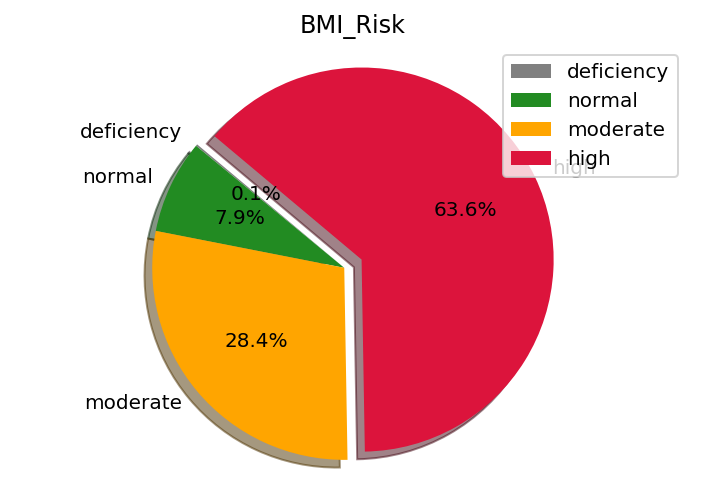

In [30]:
# sns.countplot(df['bmi_risk'])
# plt.show()

# Data to plot
labels = ['deficiency','normal','moderate','high']
sizes = [df[df['bmi_risk'] == 1]['patient_id'].count(),df[df['bmi_risk'] == 2]['patient_id'].count(),df[df['bmi_risk'] == 3]['patient_id'].count(),df[df['bmi_risk'] == 4]['patient_id'].count()]
colors = ['grey','forestgreen','orange','crimson']
explode = (0, 0,0,0.1)  # explode 1st slice

# colors=colors, explode=explode,                                                                                                        
                                                                                                       
# Plot
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', colors=colors, shadow=True, startangle=140)
 
plt.axis('equal')
plt.legend()
plt.title('BMI_Risk')

plt.show()

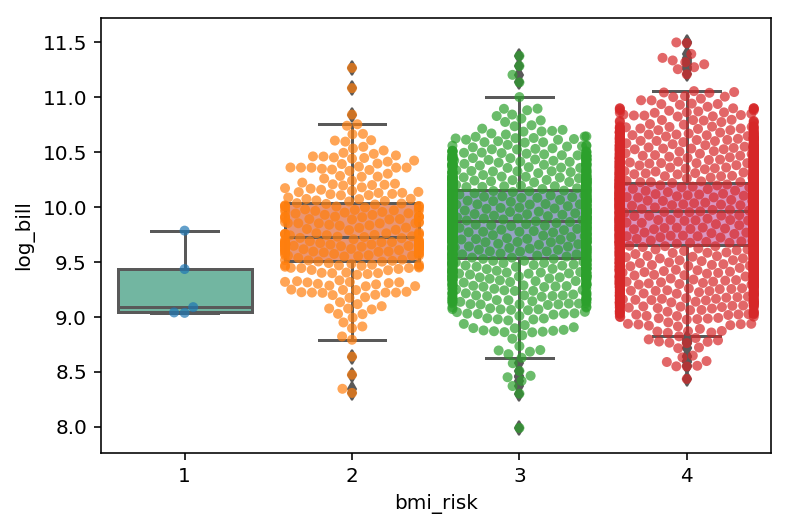

In [31]:
sns.boxplot(y=df['log_bill'],x=df['bmi_risk'],palette="Set2")
sns.swarmplot(y=df['log_bill'],x=df['bmi_risk'],alpha=0.7)

plt.show()

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.4938 0.0649   -0.02 1.0076  False
     1      3   0.5635 0.0237  0.0531 1.0739   True
     1      4   0.6572 0.0051  0.1475 1.1669   True
     2      3   0.0697 0.1031 -0.0089 0.1483  False
     2      4   0.1634  0.001  0.0896 0.2371   True
     3      4   0.0937  0.001  0.0496 0.1377   True
---------------------------------------------------


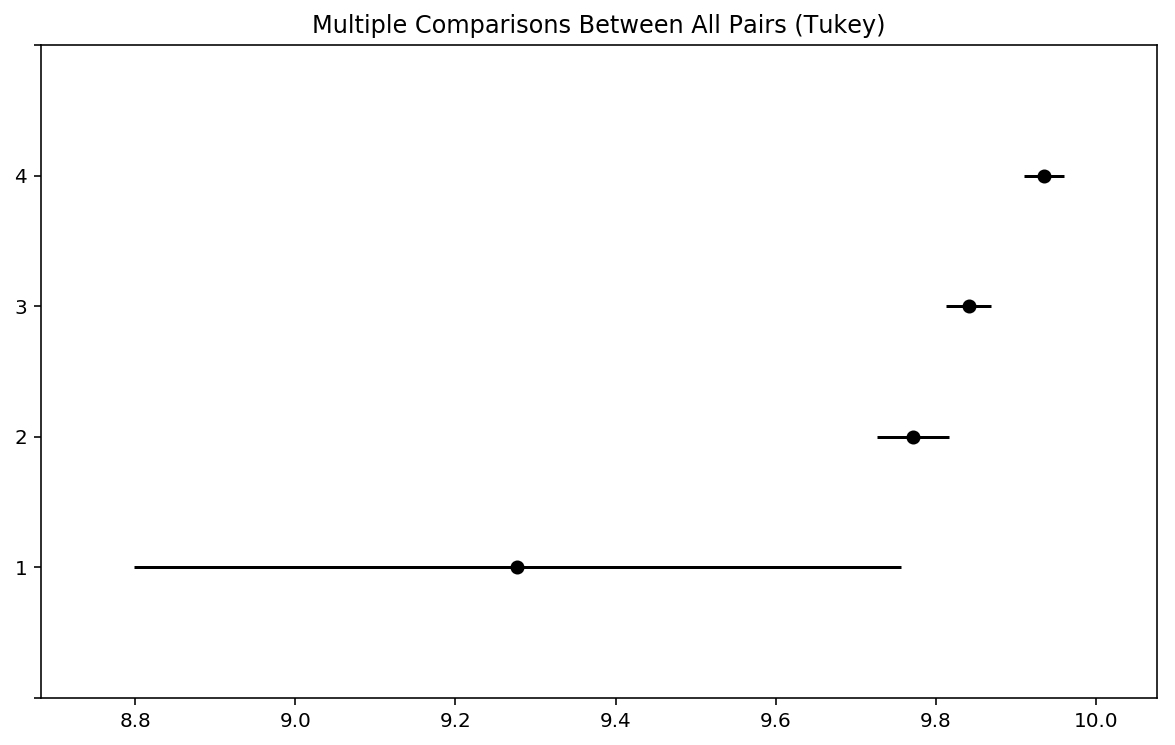

In [32]:
def tukey_hsd(df,col,aspect='log_bill'):

    # DataFrame.
    tukeyhsd = multi.pairwise_tukeyhsd(df[aspect].values,df[col].values, alpha=0.05)
    result = tukeyhsd.summary()
    print(result)

    #visualisation
    tukeyhsd.plot_simultaneous(figsize=(10,6))
    
tukey_hsd(df,'bmi_risk')

In [33]:
print()   
print('##########################')    
print('Value Count:')
print(df.groupby('bmi_risk')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df.groupby('bmi_risk')['tot_bill'].mean())
print()

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['age_grp']==0][df['bmi_risk'] == 1]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 2]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 3]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 4]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['age_grp']==1][df['bmi_risk'] == 1]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 2]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 3]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 4]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')



##########################
Value Count:
bmi_risk
1       5
2     240
3     874
4    1918
Name: patient_id, dtype: int64

Mean Total Bills:
bmi_risk
1    11200.494000
2    19408.987500
3    20731.158745
4    22689.964919
Name: tot_bill, dtype: float64

F: 10.807791349552119
P-value:  4.821663340885567e-07
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass
F: 14.196711883019981
P-value:  4.060919459845273e-09
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# Defining selected variables

In [34]:
X = df[['medical_history_1','medical_history_6','bmi_high','age_grp','foreigner','pr','malay','indian','other','symptom_5','symptom_4','symptom_3','symptom_2','symptom_1']]
y = df['tot_bill']

# Variance Inflation Factor

To check for multicolinearity

In [35]:
# Variance Inflation Factor to check for multicolinearity

# gather features
features = "+".join(X.columns)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round()

,VIF Factor,features
0,1.0,medical_history_1
1,1.0,medical_history_6
2,2.0,bmi_high
3,2.0,age_grp
4,1.0,foreigner
5,1.0,pr
6,1.0,malay
7,1.0,indian
8,1.0,other
9,2.0,symptom_5


# Linear Regression Model

Y = β0 + β1 medical history 1 + β2 medical history 6 + β3 high bmi + β4 age > 55 + 
β5 foreigner + β6 pr,+ β7 malay + β8 indian, β9 other +
β10 symptom_5 + β11 symptom_4 + β12 symptom_3 + β13 symptom_2 + β14 symptom_1

In [36]:
# Using Statsmodel

X_ = X.to_numpy()
y_ = np.log(df['tot_bill']).to_numpy()

X2 = sm.add_constant(X_)
est = sm.OLS(y_, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     3285.
Date:                Tue, 21 Sep 2021   Prob (F-statistic):               0.00
Time:                        23:30:43   Log-Likelihood:                 2471.9
No. Observations:                3400   AIC:                            -4914.
Df Residuals:                    3385   BIC:                            -4822.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7369      0.007   1184.354      0.0

In [37]:
import math

print (' total bill for patients with condition X and medical history 1 is ~', round ((math.exp(est2.params[1]) - 1) * 100,2),'% higher when compared to patients without' )
print (' total bill for patients with condition X and medical history 6 is ~', round ((math.exp(est2.params[2]) - 1) * 100,2),'% higher when compared to patients without' )
print()
print (" total bill for patients with condition X and high bmi is ~", round ((math.exp(est2.params[3]) - 1) * 100,2),"% higher when compared to patients doesn't" )
print (' total bill for patients with condition X > 55 years old is ~', round ((math.exp(est2.params[4]) - 1) * 100,2),'% higher when compared to patients < 55' )
print()
# print ('Average total bill per year for foreigner patients with condition X is ~', round ((math.exp(est2.params[6]) - 1) * 100,2),'% higher' )
# print ('Average total bill per year for PR patients with condition X is ~', round ((math.exp(est2.params[7]) - 1) * 100,2),'% higher ' )
# print ('Average total bill per year for malay patients with condition X is ~', round ((math.exp(est2.params[8]) - 1) * 100,2),'% higher when compared to patients of other races' )

# https://stats.idre.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression/

 total bill for patients with condition X and medical history 1 is ~ 32.22 % higher when compared to patients without
 total bill for patients with condition X and medical history 6 is ~ 18.41 % higher when compared to patients without

 total bill for patients with condition X and high bmi is ~ 11.12 % higher when compared to patients doesn't
 total bill for patients with condition X > 55 years old is ~ 28.24 % higher when compared to patients < 55



In [38]:
print (' total bill for patients who needs treatment/care for symptom 5 is ~', round ((math.exp(est2.params[10]) - 1) * 100,2),'% higher when compared to patients who doesnt' )
print()
print (' total bill for patients who needs treatment/care for symptom 4 is ~', round ((math.exp(est2.params[11]) - 1) * 100,2),'% higher when compared to patients who doesnt' )
print()
print (' total bill for patients who needs treatment/care for symptom 3 is ~', round ((math.exp(est2.params[12]) - 1) * 100,2),'% higher when compared to patients who doesnt' )
print()
print (' total bill for patients who needs treatment/care for symptom 2 is ~', round ((math.exp(est2.params[13]) - 1) * 100,2),'% higher when compared to patients who doesnt' )
print()
print (' total bill for patients who needs treatment/care for symptom 1 is ~', round ((math.exp(est2.params[14]) - 1) * 100,2),'% higher when compared to patients who doesnt' )
print()

 total bill for patients who needs treatment/care for symptom 5 is ~ 67.1 % higher when compared to patients who doesnt

 total bill for patients who needs treatment/care for symptom 4 is ~ 19.6 % higher when compared to patients who doesnt

 total bill for patients who needs treatment/care for symptom 3 is ~ 21.89 % higher when compared to patients who doesnt

 total bill for patients who needs treatment/care for symptom 2 is ~ 20.87 % higher when compared to patients who doesnt

 total bill for patients who needs treatment/care for symptom 1 is ~ 14.84 % higher when compared to patients who doesnt



# Decision Tree Model

In [39]:
regr = DecisionTreeRegressor(random_state=222,max_depth=14)
regr.fit(X,y)

print ('R2 Score: ', regr.score(X,y) )

impt = pd.DataFrame(index=X.columns)
impt['impt'] = regr.feature_importances_
impt = impt.sort_values('impt',ascending=False)

R2 Score:  0.9782756552313088


In [40]:
impt

,impt
symptom_5,0.273002
foreigner,0.200206
malay,0.182267
age_grp,0.084724
medical_history_1,0.053423
symptom_3,0.036132
symptom_2,0.032927
medical_history_6,0.028756
pr,0.026896
symptom_1,0.021985


In [41]:
import graphviz
dot_data = tree.export_graphviz(regr, out_file=None, 
                                feature_names=X.columns,  
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 

In [42]:
# graph.render("decision_tree_graphivz")

In [43]:
# graph